<a href="https://colab.research.google.com/github/roshan-k-patel/APCOMP2090A-workbooks/blob/master/209a_sec08_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science

# Section 8: Classification
### (kNN Classification, Logistic Regression, Multiple Logistic Regression)

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas & Kevin Rader<br/>
<hr style='height:2px'>

## Sections:
1. Data Loading
2. Binary Classification: Penguin Sex
3. Multiclass Classification: Penguin Species

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,\
                                    cross_val_predict, KFold, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures,\
                                    OneHotEncoder, LabelBinarizer, label_binarize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# Use the same random state throughout
random_state = 209

# Binary Classification

In this section we will try to predict the sex of the penguins in the now familiar peguins dataset.

In [ ]:
df = sns.load_dataset('penguins')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [ ]:
df.shape

(344, 7)

In [ ]:
df.isna().sum(axis=0)

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11


In [ ]:
# Do some rows have more than a single missing value?
df[df.isna().sum(axis=1) > 1]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Yuck! These are useless. Drop these rows
df = df[df.isna().sum(axis=1) <= 1]

In [ ]:
# Confirm that now sex is the only feature with missingness
df.isna().sum(axis=0)

,0
species,0
island,0
bill_length_mm,0
bill_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,9


In [ ]:
# Create stratification variable (NaN values will be treated as their own group)
stratify_var = df['sex'].astype(str) + '_' + df['species']

print("Distribution of sex-species combinations (including NaN):")
print(stratify_var.value_counts())

Distribution of sex-species combinations (including NaN):
Male_Adelie         73
Female_Adelie       73
Male_Gentoo         61
Female_Gentoo       58
Male_Chinstrap      34
Female_Chinstrap    34
nan_Adelie           5
nan_Gentoo           4
Name: count, dtype: int64


In [ ]:
# Single train-test split stratifying on both sex and species
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=random_state,
    stratify=stratify_var
)

In [ ]:
# Quick look at class balance for sex across split
print("TRAIN")
print(df_train['sex'].value_counts(normalize=True))
print("TEST")
print(df_test['sex'].value_counts(normalize=True))

TRAIN
sex
Male      0.503759
Female    0.496241
Name: proportion, dtype: float64
TEST
sex
Male      0.507463
Female    0.492537
Name: proportion, dtype: float64


In [ ]:
# Create alternate train & test dfs without missing sex
df_train_sex = df_train.dropna(subset='sex')
df_test_sex = df_test.dropna(subset='sex')

In [ ]:
# Confirm there is no more missingness
assert df_train_sex.isna().sum().sum() == 0
assert df_test_sex.isna().sum().sum() == 0

In [ ]:
# X
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
response = 'sex'
X_train = df_train_sex[features]
X_test = df_test_sex[features]

# y
# Encode sex as 0/1
le = LabelEncoder()
y_train = le.fit_transform(df_train_sex[response])
y_test = le.transform(df_test_sex['sex'])

# Show encoding mapping
print("\nEncoding mapping:")
for i, label in enumerate(le.classes_):
    print(f"{label} -> {i}")


Encoding mapping:
Female -> 0
Male -> 1


In [ ]:
y_train

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1])

## kNN Classifier

The works just like kNN Regression except instead of predicting the average of the neighbors' $y$ value, we predict the *mode*. That is, the majority class label seen in the neighbors.

**Q:** Why do we want to use scaling here?

In [ ]:
cv_folds = 5

# Create the pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {'knn__n_neighbors': np.arange(1, 31)}

# Create KFold object
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# Create and fit GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Fit the grid search
print("Starting grid search...")
grid_search.fit(X_train, y_train)

# Create DataFrame with CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
knn_cv_acc = grid_search.best_score_

# Print best parameters and score
print("\nBest parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation accuracy: {knn_cv_acc:.4f}")

best_knn = grid_search.best_estimator_
best_knn

Starting grid search...

Best parameters:
knn__n_neighbors: 6

Best cross-validation accuracy: 0.9212


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=np.int64(6)))])

## Decision Boundary for kNN Classifier

In [ ]:
def plot_decision_boundary(model, X, y, use_pca=False, feature1='bill_depth_mm', feature2='body_mass_g'):
    """
    Plot binary decision boundary for classifier pipelines with orange and teal colors.
    Can plot either in original feature space or PCA space.

    Parameters:
    -----------
    model : sklearn Pipeline or classifier
        Trained pipeline (with preprocessing steps) or standalone classifier
    X : array-like or DataFrame
        Features used for training
    y : array-like
        Target values (binary)
    use_pca : bool
        If True, plot in PCA space using first two components
    feature1 : str
        Name of first feature to plot (ignored if use_pca=True)
    feature2 : str
        Name of second feature to plot (ignored if use_pca=True)
    """
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a pandas DataFrame")

    if use_pca:
        # Check if model is a pipeline with PCA
        if isinstance(model, Pipeline) and any(isinstance(step[1], PCA) for step in model.steps):
            # Find PCA and previous steps in the pipeline
            pca_idx = next(i for i, (name, step) in enumerate(model.steps)
                          if isinstance(step, PCA))
            preprocessing_steps = Pipeline(model.steps[:pca_idx + 1])
            classifier_steps = Pipeline(model.steps[pca_idx + 1:])

            # Transform data using preprocessing steps including PCA
            X_pca = preprocessing_steps.transform(X)
        else:
            # Create and fit a new pipeline with StandardScaler and PCA just for visualization
            viz_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=2))
            ])
            X_pca = viz_pipeline.fit_transform(X)

        # Use first two PCA components
        x1_min, x1_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
        x2_min, x2_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5

        xx1, xx2 = np.meshgrid(
            np.linspace(x1_min, x1_max, 100),
            np.linspace(x2_min, x2_max, 100)
        )

        # Create mesh points in PCA space
        X_mesh = np.column_stack([xx1.ravel(), xx2.ravel()])

        if isinstance(model, Pipeline) and any(isinstance(step[1], PCA) for step in model.steps):
            # If model has PCA, use classifier steps for prediction
            Z = classifier_steps.predict(X_mesh)
            if hasattr(classifier_steps, 'predict_proba'):
                Z_proba = classifier_steps.predict_proba(X_mesh)[:, 1]
        else:
            # If using visualization PCA, transform mesh back to original space
            X_mesh_original = viz_pipeline.inverse_transform(X_mesh)
            X_mesh_df = pd.DataFrame(X_mesh_original, columns=X.columns)
            Z = model.predict(X_mesh_df)
            if hasattr(model, 'predict_proba'):
                Z_proba = model.predict_proba(X_mesh_df)[:, 1]

        plot_x = X_pca[:, 0]
        plot_y = X_pca[:, 1]
        xlabel = 'First Principal Component'
        ylabel = 'Second Principal Component'

    else:
        # Original feature space plotting code
        feature1_idx = X.columns.get_loc(feature1)
        feature2_idx = X.columns.get_loc(feature2)

        x1_min, x1_max = X[feature1].min() - 0.5, X[feature1].max() + 0.5
        x2_min, x2_max = X[feature2].min() - 0.5, X[feature2].max() + 0.5

        xx1, xx2 = np.meshgrid(
            np.linspace(x1_min, x1_max, 100),
            np.linspace(x2_min, x2_max, 100)
        )

        feature_means = X.mean()
        mesh_shape = xx1.ravel().shape[0]
        mesh_dict = {col: np.repeat(feature_means[col], mesh_shape) for col in X.columns}
        mesh_dict[feature1] = xx1.ravel()
        mesh_dict[feature2] = xx2.ravel()

        X_mesh = pd.DataFrame(mesh_dict, columns=X.columns)
        Z = model.predict(X_mesh)
        if hasattr(model, 'predict_proba'):
            Z_proba = model.predict_proba(X_mesh)[:, 1]

        plot_x = X[feature1]
        plot_y = X[feature2]
        xlabel = feature1
        ylabel = feature2

    Z_binary = Z.reshape(xx1.shape)

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Define colors
    region_colors = ['#FFE5CC', '#CCE5E5']  # Light orange, Light teal
    scatter_colors = ['#FF8C1A', '#008080']  # Darker orange, Darker teal

    # Plot decision boundary
    plt.contourf(xx1, xx2, Z_binary, alpha=0.3, levels=[-1, 0.5, 1],
                colors=region_colors)

    # If model has predict_proba, plot probability contours
    if hasattr(model, 'predict_proba') or (isinstance(model, Pipeline) and
            hasattr(model.steps[-1][1], 'predict_proba')):
        Z_proba = Z_proba.reshape(xx1.shape)
        plt.contour(xx1, xx2, Z_proba, levels=[0.5], colors='black', linewidths=2)

    # Plot the points
    plt.scatter(
        plot_x,
        plot_y,
        c=[scatter_colors[int(val)] for val in y],
        alpha=0.8
    )

    # Create legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_colors[0],
                  label='Female', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_colors[1],
                  label='Male', markersize=10)
    ]
    plt.legend(handles=legend_elements, title='Sex')

    # Get model name
    if isinstance(model, Pipeline):
        classifier = model.steps[-1][1]
        model_name = (
            'Logistic Regression' if isinstance(classifier, LogisticRegression)
            else 'K-Nearest Neighbors' if isinstance(classifier, KNeighborsClassifier)
            else 'Classifier'
        )
    else:
        model_name = (
            'Logistic Regression' if isinstance(model, LogisticRegression)
            else 'K-Nearest Neighbors' if isinstance(model, KNeighborsClassifier)
            else 'Classifier'
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    title = f'{model_name} Decision Boundary'
    if use_pca:
        title += ' (PCA Space)'
    plt.title(title)

    plt.show()

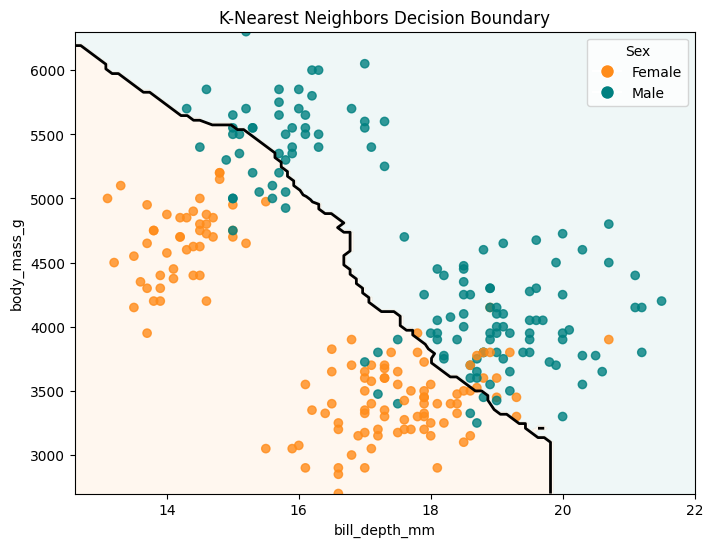

In [ ]:
plot_decision_boundary(best_knn, X_train, y_train, use_pca=False)

### Why not Linear Regression for Classification?

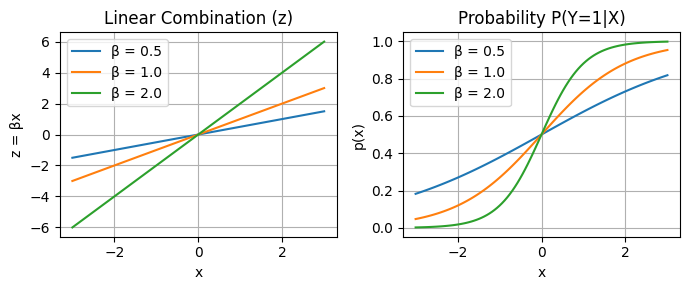

In [ ]:
def plot_linear_to_probability():
    x = np.linspace(-3, 3, 100)
    betas = [0.5, 1.0, 2.0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

    for beta in betas:
        z = beta * x
        p = 1/(1 + np.exp(-z))

        ax1.plot(x, z, label=f'β = {beta}')
        ax2.plot(x, p, label=f'β = {beta}')

    ax1.set_title('Linear Combination (z)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z = βx')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Probability P(Y=1|X)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('p(x)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

plot_linear_to_probability()

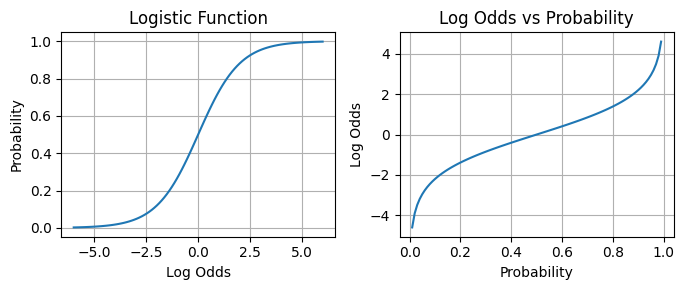

In [ ]:
def create_logistic_visualization():
    x = np.linspace(-6, 6, 100)
    p = 1/(1 + np.exp(-x))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

    # Plot logistic function
    ax1.plot(x, p)
    ax1.set_title('Logistic Function')
    ax1.set_xlabel('Log Odds')
    ax1.set_ylabel('Probability')
    ax1.grid(True)

    # Plot log odds vs probability
    p_range = np.linspace(0.01, 0.99, 100)
    log_odds = np.log(p_range/(1-p_range))

    ax2.plot(p_range, log_odds)
    ax2.set_title('Log Odds vs Probability')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Log Odds')
    ax2.grid(True)

    plt.tight_layout()
    return fig

fig = create_logistic_visualization()

## Maximum Likelihood Estimation → Loss Functions

### Binary Case: Y ~ Bernoulli

#### 1. Model Assumption
For each observation i, assume Yi follows a Bernoulli distribution:
$$ Y_i \sim \text{Bernoulli}(p_i) $$

where pi is a function of our predictors:
$$ p_i = P(Y_i=1|X_i) = \frac{1}{1 + e^{-\beta^T x_i}} $$

#### 2. Likelihood Function
The probability mass function for a single observation is:
$$ P(Y_i = y_i) = p_i^{y_i}(1-p_i)^{1-y_i} $$

Assuming independent observations, the likelihood for all observations is:
$$ L(\beta) = \prod_{i=1}^n p_i^{y_i}(1-p_i)^{1-y_i} $$

#### 3. Log-Likelihood
Taking the log (to convert product to sum):
$$ \ell(\beta) = \sum_{i=1}^n [y_i\log(p_i) + (1-y_i)\log(1-p_i)] $$

#### 4. Substitute Model for pi
$$ \ell(\beta) = \sum_{i=1}^n \left[y_i\log\left(\frac{1}{1 + e^{-\beta^T x_i}}\right) + (1-y_i)\log\left(1 - \frac{1}{1 + e^{-\beta^T x_i}}\right)\right] $$

#### 5. Loss Function
The negative log-likelihood (our loss function) is:
$$ L(\beta) = -\ell(\beta) = -\sum_{i=1}^n [y_i\log(p_i) + (1-y_i)\log(1-p_i)] $$

This is the binary cross-entropy loss!

## Logistic Regression with SKLearn

In [ ]:
# Create basic logistic regression without scaling
lr = LogisticRegression(random_state=random_state,
                        penalty=None,
                        max_iter=1000)

# Fit the model on all training data
lr.fit(X_train, y_train)

# Get cross validation scores using the same KFold object
lr_cv_scores = cross_val_score(
    lr,
    X_train,
    y_train,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate mean CV accuracy
lr_cv_acc = lr_cv_scores.mean()

print(f"Cross-validation accuracy: {lr_cv_acc:.4f}")

Cross-validation accuracy: 0.9136


## Interpreting the Coefficients

Let's inspect the coefficients of our first logistic regression model.

In [ ]:
# Let's interpret the unregularized model's coefficients
unreg_coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr.coef_[0],  # [0] because binary classification returns 1 row
    'Odds_Ratio': np.exp(lr.coef_[0])
})
unreg_coef_df = unreg_coef_df.sort_values('Coefficient', ascending=False)

print("Unregularized Model Coefficients:")
print(unreg_coef_df)
print("\nIntercept:", lr.intercept_[0])

Unregularized Model Coefficients:
             Feature  Coefficient  Odds_Ratio
1      bill_depth_mm     1.931415    6.899266
0     bill_length_mm     0.214036    1.238667
3        body_mass_g     0.005718    1.005734
2  flipper_length_mm    -0.084347    0.919112

Intercept: -49.52105684515016


Remember, the logistic regression coefficients describe a linear relationship between the features and the *log-odds*, not the probability!

## LASSO Regularized Logistic Regression

For logistic regression models, SKLearn calls the regularization `C`. **Be careful! This is $\frac{1}{\lambda}$.** So a larger `C` means a smaller penalty and thus *less* regularization.

If we want to use LASSO we need to set `pentaly='l1'`. The default solver not work with LASSO so we need to set `solver='liblinear'`.

**Q:** Why are we scaling here when we didn't in the previous model?

In [ ]:
# Create pipeline with scaling and LogisticRegressionCV
Cs = np.logspace(-3, 3, 100)
reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr_cv', LogisticRegressionCV(
        Cs=Cs,
        penalty='l1',
        cv=kf,  # Using same KFold object for fair comparison
        scoring='accuracy',
        random_state=random_state,
        solver='liblinear',
        n_jobs=-1
    ))
])

# Fit the model
print("Fitting regularized model...")
reg_pipeline.fit(X_train, y_train)

# Get the best C value and CV accuracy
best_C = reg_pipeline.named_steps['lr_cv'].C_[0]  # [0] for binary classification
reg_cv_acc = reg_pipeline.named_steps['lr_cv'].scores_[1].mean(axis=0).max()

print(f"\nBest C: {best_C:.4f}")
print(f"CV accuracy: {reg_cv_acc:.4f}")

Fitting regularized model...

Best C: 4.9770
CV accuracy: 0.9136


## Interpreting the Regularized Coefficients

The feature scaling can confuse interpetation if you aren't careful!

In [ ]:
# For regularized model
scaler = reg_pipeline.named_steps['scaler']
reg_lr = reg_pipeline.named_steps['lr_cv']

# Get standardized coefficients for feature importance
standardized_coef = reg_lr.coef_[0]  # These are already in standardized scale

# Get original scale coefficients for interpretation
original_scale_coef = standardized_coef / scaler.scale_

# Create comparison DataFrame with both scales
comparison_df = pd.DataFrame({
    'Feature': features,
    'Standardized_Coef': standardized_coef,
    'Original_Scale_Coef': original_scale_coef,
    'Original_Scale_Odds': np.exp(original_scale_coef)
})

# Sort by absolute standardized coefficient for feature importance
comparison_df['Abs_Standardized_Coef'] = abs(comparison_df['Standardized_Coef'])
comparison_df = comparison_df.sort_values('Abs_Standardized_Coef', ascending=False).reset_index(drop=True)

print("\nFeature Importance and Interpretation:")
comparison_df


Feature Importance and Interpretation:


,Feature,Standardized_Coef,Original_Scale_Coef,Original_Scale_Odds,Abs_Standardized_Coef
0,body_mass_g,4.383679,0.005411,1.005426,4.383679
1,bill_depth_mm,3.697516,1.877035,6.534100,3.697516
2,bill_length_mm,1.079517,0.200701,1.222259,1.079517
3,flipper_length_mm,-1.022117,-0.073143,0.929468,1.022117


#### Comparison to the unregularized coefficients

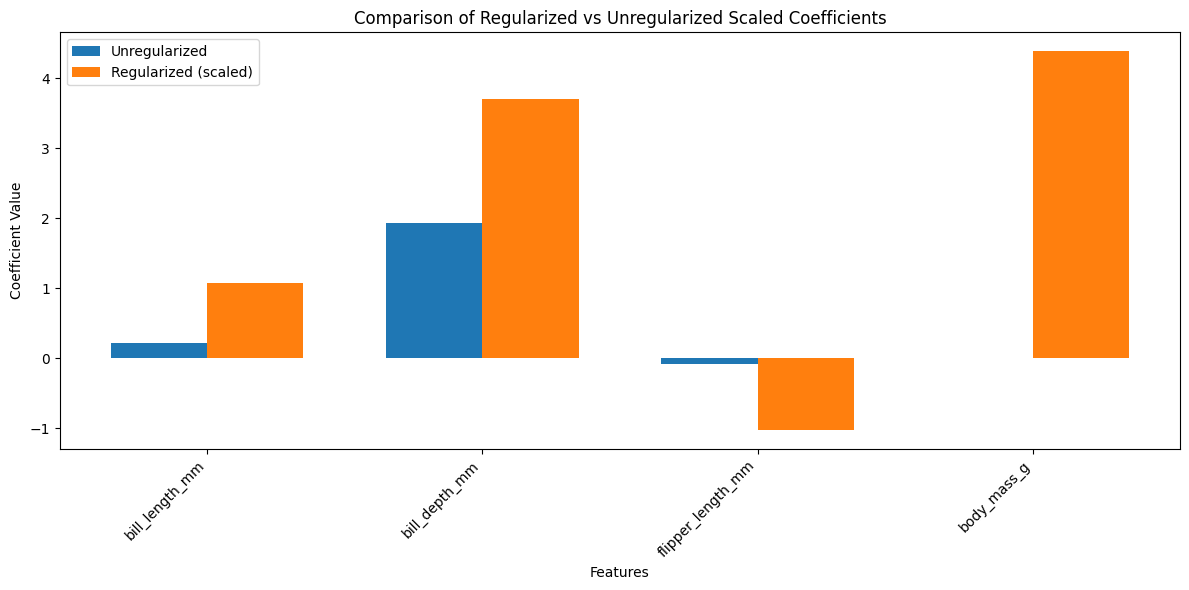

In [ ]:
# Visualize coefficient comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(features))
width = 0.35

plt.bar(x - width/2, lr.coef_[0], width, label='Unregularized')
plt.bar(x + width/2, standardized_coef, width, label='Regularized (scaled)')
plt.xticks(x, features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Regularized vs Unregularized Scaled Coefficients')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
best_2_features = comparison_df.loc[:1, "Feature"].values
best_2_features

array(['body_mass_g', 'bill_depth_mm'], dtype=object)

In [ ]:
USE_BEST_2_FEATURES = False
features = best_2_features if USE_BEST_2_FEATURES else ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [ ]:
lr_2features = LogisticRegression(penalty=None, random_state=random_state).fit(X_train[features], y_train)
random_state = 209
lr_2features.intercept_, lr_2features.coef_

(array([-49.52105685]),
 array([[ 0.21403559,  1.93141508, -0.08434697,  0.00571781]]))

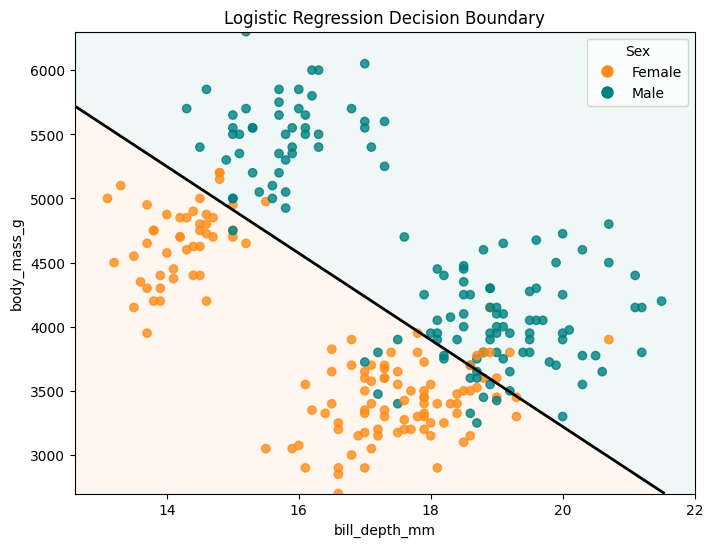

In [ ]:
plot_decision_boundary(lr_2features, X_train[features], y_train)

## Regularized Polynomial Logistic Regression

In [ ]:
# Create pipeline with polynomial features, scaling, and Lasso logistic regression
max_iter = 1000
poly_lasso_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lr_cv', LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 20),
        cv=kf,
        scoring='accuracy',
        penalty='l1',
        solver='liblinear',  # Required for L1 penalty
        random_state=random_state,
        max_iter=max_iter,
        n_jobs=-1
    ))
])

# Fit the model
print("Fitting Lasso model with polynomial features...")
poly_lasso_pipeline.fit(X_train[features], y_train)

# Get CV accuracy
lasso_cv_acc = poly_lasso_pipeline.named_steps['lr_cv'].scores_[1].mean(axis=0).max()
print(f"\nBest CV accuracy: {lasso_cv_acc:.4f}")
print(f"Best C: {poly_lasso_pipeline.named_steps['lr_cv'].C_[0]:.4f}")

# Get feature names from polynomial transformation
feature_names_poly = poly_lasso_pipeline.named_steps['poly'].get_feature_names_out(X_train[features].columns)

# Get coefficients
lasso_coef = poly_lasso_pipeline.named_steps['lr_cv'].coef_[0]

# Create DataFrame of features and their coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names_poly,
    'Coefficient': lasso_coef
})

# Sort by absolute coefficient value and show non-zero coefficients
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df[coef_df['Coefficient'] != 0].sort_values('Abs_Coefficient', ascending=False)

print("\nNon-zero coefficients:")
print(coef_df[['Feature', 'Coefficient']].to_string())

Fitting Lasso model with polynomial features...

Best CV accuracy: 0.9096
Best C: 0.1624

Non-zero coefficients:
                         Feature  Coefficient
10     bill_depth_mm body_mass_g     1.467104
26   bill_depth_mm^2 body_mass_g     1.180597
5   bill_length_mm bill_depth_mm     0.632566


## Non-linear Decision Boundaries (in original feature space)

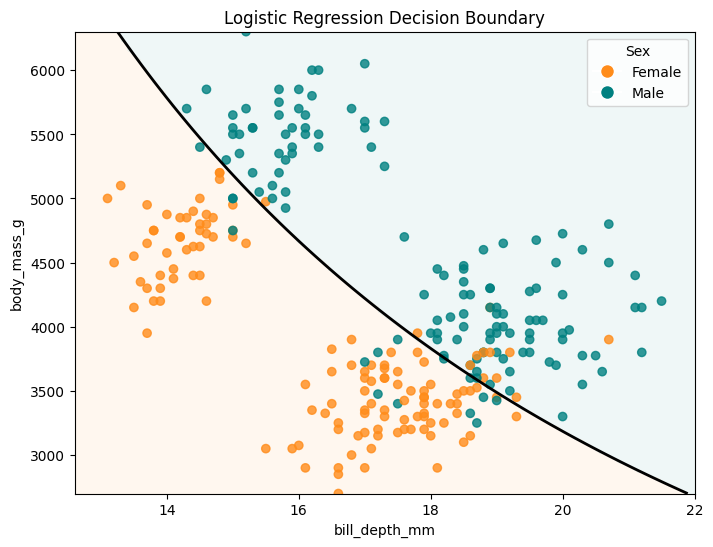

In [ ]:
plot_decision_boundary(poly_lasso_pipeline, X_train[features], y_train)

## ROC Curves & AUC

In [ ]:
def plot_roc_curves_binary(models, X, y, cv=None):
    plt.figure(figsize=(10, 8))

    # Dictionary to store AUC for each model
    aucs = {}

    for name, model in models.items():
        if cv is not None:
            # Get cross-validated probabilities
            y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        else:
            y_proba = model.predict_proba(X)

        # Calculate ROC curve and ROC area using probabilities of class 1
        fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        aucs[name] = roc_auc

        # Plot ROC curve for this model
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if cv is not None:
        subtitle = 'Cross-Validated'
    # Assume we are using test data if not cross validating
    else:
        subtitle = 'Test'
    plt.title(f'ROC Curves ({subtitle})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return aucs

### Cross-Validated ROC curves and AUC scores

ROC curves and AUC (area under the cuve) scores help us understand how well our model will perform across all possible decision thresholds, not just 0.5!


Generating cross-validated ROC curves...


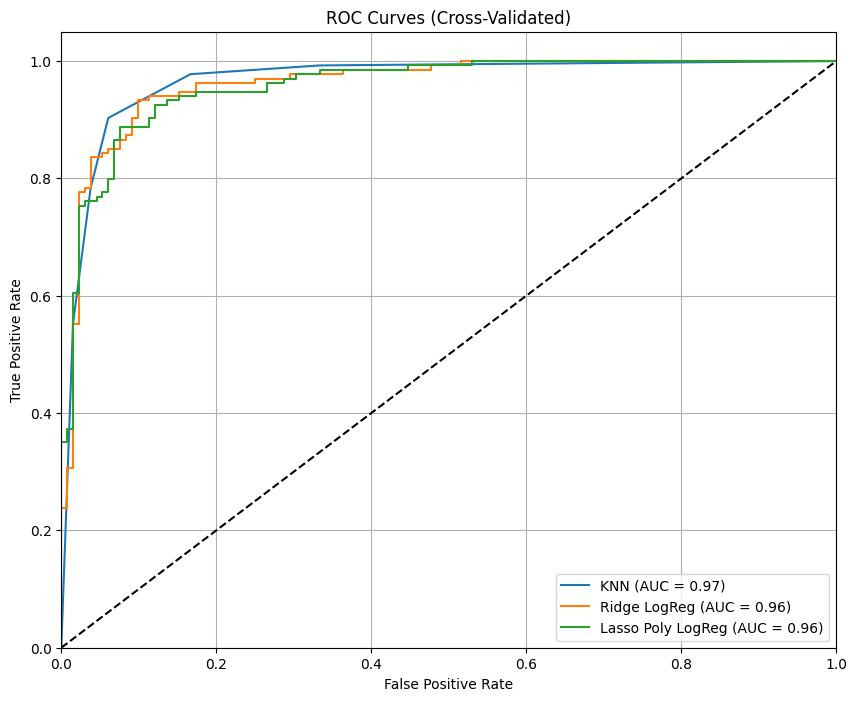

In [ ]:
models = {
    'KNN': best_knn,
    'Ridge LogReg': reg_pipeline,
    'Lasso Poly LogReg': poly_lasso_pipeline
}

# Plot ROC curves and get AUC scores using training data
print("\nGenerating cross-validated ROC curves...")
aucs = plot_roc_curves_binary(models, X_train, y_train, cv=kf)

### Test Performance

We can inspect the final model performance here, but we really should only perform model selection based on the cross-validation results!


Generating ROC curves...


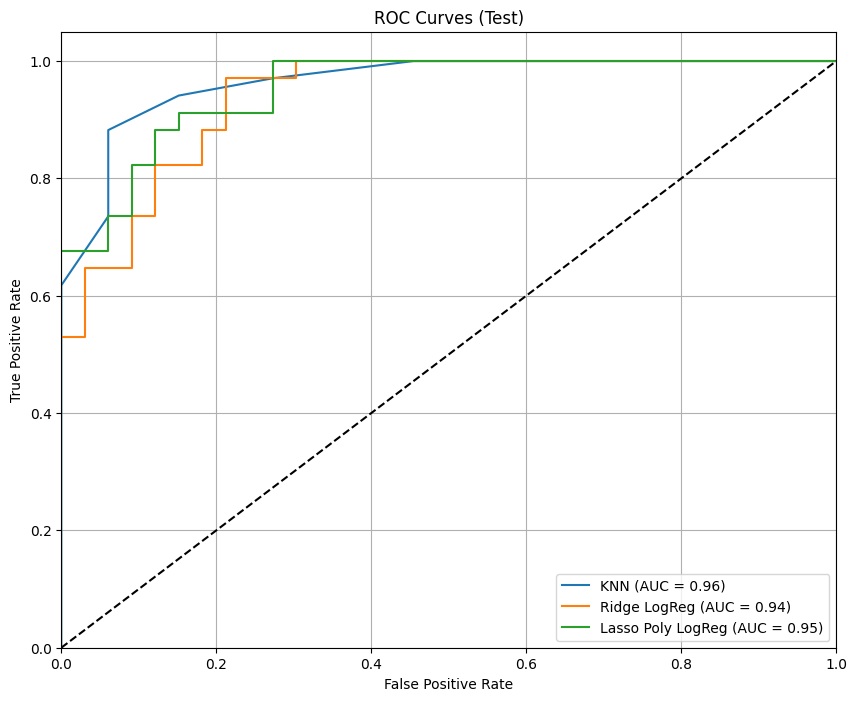

In [ ]:
print("\nGenerating ROC curves...")
aucs = plot_roc_curves_binary(models, X_test, y_test)

## Predicting Species

### Multiclass Case: Y ~ Multinomial

#### 1. Model Assumption
For each observation i, assume Yi follows a Multinomial distribution (with n=1):
$$ Y_i \sim \text{Multinomial}(1, p_{i1},...,p_{iK}) $$

where for each class k:
$$ p_{ik} = P(Y_i=k|X_i) = \frac{e^{\beta_k^T x_i}}{\sum_{j=1}^K e^{\beta_j^T x_i}} $$

#### 2. Likelihood Function
For one observation:
$$ P(Y_i) = \prod_{k=1}^K p_{ik}^{I(y_i=k)} $$

For all observations:
$$ L(\beta) = \prod_{i=1}^n \prod_{k=1}^K p_{ik}^{I(y_i=k)} $$

#### 3. Log-Likelihood
$$ \ell(\beta) = \sum_{i=1}^n \sum_{k=1}^K I(y_i=k)\log(p_{ik}) $$

#### 4. Substitute Model for pik
$$ \ell(\beta) = \sum_{i=1}^n \sum_{k=1}^K I(y_i=k)\log\left(\frac{e^{\beta_k^T x_i}}{\sum_{j=1}^K e^{\beta_j^T x_i}}\right) $$

#### 5. Loss Function
$$ L(\beta) = -\ell(\beta) = -\sum_{i=1}^n \sum_{k=1}^K I(y_i=k)\log(p_{ik}) $$

This is the multiclass cross-entropy loss!

### Set up our predictors

In [ ]:
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
response = ['species']
X_train = df_train[features]
X_test = df_test[features]
X_train.loc[:,'sex'] = (X_train.sex == "Female").astype(int)
X_test.loc[:,'sex'] = (X_test.sex == "Female").astype(int)

And the response (which needs to be encoded)

In [ ]:
def encode_species_multiple_ways(df_train, df_test, response_col='species'):
    """
    Demonstrate different ways to encode species for multiclass classification

    Parameters:
    -----------
    df_train : pandas.DataFrame
        Training data containing species column
    df_test : pandas.DataFrame
        Test data containing species column
    response_col : str
        Name of the species column

    Returns:
    --------
    dict : Dictionary containing different encodings
    """
    results = {}

    # 1. Label Encoding (0, 1, 2)
    le = LabelEncoder()
    y_train_label = le.fit_transform(df_train[response_col])
    y_test_label = le.transform(df_test[response_col])

    results['label_encoding'] = {
        'train': y_train_label,
        'test': y_test_label,
        'classes': le.classes_,
        'le': le,
        'mapping': {label: idx for idx, label in enumerate(le.classes_)}
    }

    # 2. One-Hot Encoding (sparse matrix by default)
    ohe = OneHotEncoder(sparse_output=False)
    y_train_onehot = ohe.fit_transform(df_train[[response_col]])
    y_test_onehot = ohe.transform(df_test[[response_col]])

    results['onehot_encoding'] = {
        'train': y_train_onehot,
        'test': y_test_onehot,
        'feature_names': ohe.get_feature_names_out([response_col]),
        'categories': ohe.categories_[0]
    }

    # 3. Label Binarizer (dense matrix)
    lb = LabelBinarizer()
    y_train_binary = lb.fit_transform(df_train[response_col])
    y_test_binary = lb.transform(df_test[response_col])

    results['label_binarizer'] = {
        'train': y_train_binary,
        'test': y_test_binary,
        'classes': lb.classes_
    }

    return results

def print_encoding_examples(encodings, sample_species):
    """Print examples of each encoding type"""
    print("Example encodings for species:", sample_species)
    print("\n1. Label Encoding:")
    print("Mapping:", encodings['label_encoding']['mapping'])

    print("\n2. One-Hot Encoding:")
    print("Feature names:", encodings['onehot_encoding']['feature_names'])
    print("Example array shape:", encodings['onehot_encoding']['train'].shape)
    print("Example row:", encodings['onehot_encoding']['train'][0])

    print("\n3. Label Binarizer:")
    print("Classes:", encodings['label_binarizer']['classes'])
    print("Example array shape:", encodings['label_binarizer']['train'].shape)
    print("Example row:", encodings['label_binarizer']['train'][0])

# Encode species using all methods
encodings = encode_species_multiple_ways(df_train, df_test)

# Print examples
sample_species = df_train['species'].iloc[0]
print_encoding_examples(encodings, sample_species)

Example encodings for species: Chinstrap

1. Label Encoding:
Mapping: {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}

2. One-Hot Encoding:
Feature names: ['species_Adelie' 'species_Chinstrap' 'species_Gentoo']
Example array shape: (273, 3)
Example row: [0. 1. 0.]

3. Label Binarizer:
Classes: ['Adelie' 'Chinstrap' 'Gentoo']
Example array shape: (273, 3)
Example row: [0 1 0]


In [ ]:
# Choose your preferred encoding:
y_train = encodings['label_encoding']['train']
y_test = encodings['label_encoding']['test']
le = encodings['label_encoding']['le']

In [ ]:
y_train

array([1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2,
       2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2, 1,
       1, 1, 2, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 0, 0, 0, 1,
       0, 2, 2, 2, 1, 2, 0, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0,
       1, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 0, 0,
       0, 1, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1,
       2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 2, 2, 0, 0, 0,
       2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2,
       0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 2,
       0, 0, 0, 2, 0, 0, 2, 0, 0])

In [ ]:
# Initialize empty DataFrame for scores
scores_df = pd.DataFrame(columns=['Model', 'Train Score', 'CV Score', 'Validation AUC'])

### Multiclass with kNN

In [ ]:
# KNN with GridSearchCV
print("Fitting KNN model...")
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'knn__n_neighbors': [1, 2, 3, 4, 5, 7, 9, 11],
}

knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=kf, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# Get KNN scores
knn_train_score = knn_grid.score(X_train, y_train)
knn_cv_score = knn_grid.best_score_

print(f"\nBest KNN parameters: {knn_grid.best_params_}")
print(f"KNN Train score: {knn_train_score:.4f}")
print(f"KNN CV score: {knn_cv_score:.4f}")

Fitting KNN model...

Best KNN parameters: {'knn__n_neighbors': 1}
KNN Train score: 1.0000
KNN CV score: 0.9963


### Multiclass Ridge Logistic Regression

In [ ]:
# Ridge Logistic Regression (on original features)
print("\nFitting Ridge Logistic Regression model...")
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegressionCV(
        Cs=Cs,
        cv=kf,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        scoring='accuracy'
    ))
])

ridge_pipeline.fit(X_train, y_train)

# Get Ridge scores
ridge_train_score = ridge_pipeline.score(X_train, y_train)
ridge_cv_score = ridge_pipeline.named_steps['logistic'].scores_[1].mean()

print(f"Ridge Logistic Regression Train score: {ridge_train_score:.4f}")
print(f"Ridge Logistic Regression CV score: {ridge_cv_score:.4f}")



Fitting Ridge Logistic Regression model...
Ridge Logistic Regression Train score: 0.9927
Ridge Logistic Regression CV score: 0.9554


In [ ]:
# Lasso Logistic Regression with Polynomial Features
print("\nFitting Lasso Polynomial Logistic Regression model...")
poly_lasso_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegressionCV(
        Cs=Cs,
        cv=kf,
        penalty='l1',
        solver='saga', # our only solver option for l1 multiclass! See docs
        max_iter=10000,
        scoring='accuracy'
    ))
])

poly_lasso_pipeline.fit(X_train, y_train)

# Get Lasso scores
lasso_train_score = poly_lasso_pipeline.score(X_train, y_train)
lasso_cv_score = poly_lasso_pipeline.named_steps['logistic'].scores_[1].mean()

print(f"Lasso Polynomial Logistic Regression Train score: {lasso_train_score:.4f}")
print(f"Lasso Polynomial Logistic Regression CV score: {lasso_cv_score:.4f}")



Fitting Lasso Polynomial Logistic Regression model...
Lasso Polynomial Logistic Regression Train score: 0.9963
Lasso Polynomial Logistic Regression CV score: 0.8764


Hmm... which model to select?

The Lasso model seems to be overfitting given the big difference between training and cross-validation scores.

kNN had the highest CV score, but the training accuracy is 100%. Not surprising given it selected $k=1$ as the best $k$! That model seems very prone to overfitting as well, despite what the validation error may suggest.

The Ridge model still had relatively high CV accuracy that is not too different from its training performance, suggesting it is not (too) over fit. Let's go with the Ridge model.

In [ ]:
# Evaluate selected model on test data
ridge_pipeline.score(X_test, y_test)

1.0

Wowee! 😲